In [1]:
import Pkg; Pkg.activate("C:/Users/s151781/AppData/Local/Julia-1.3.1/GN/Project.toml")
using LinearAlgebra
using PyPlot
using Compat
using WAV
using Base64
using DSP
using FFTW
using Distributions
using GaussianMixtures
using ProgressMeter
using BenchmarkTools

include("../functions/auxiliary/audioplayer.jl")
include("../functions/auxiliary/workflow.jl")
include("../functions/preprocessing.jl")
;

Activating environment at `C:\Users\s151781\AppData\Local\Julia-1.3.1\GN\Project.toml`


┌ Info: Precompiling GaussianMixtures [cc18c42c-b769-54ff-9e2a-b28141a64aae]
└ @ Base loading.jl:1273


In [234]:
# signal preprocessing
sound_file1 = "../data/woman.wav"     # specify sound location
sound_file2 = "../data/leaves.wav"     # specify sound location
fs_desired = 8000                     # specify desired sampling frequency
normalization_method = "max"          # specify normalization method
μ = 255                               # specify parameter for μ-law companding and expansion
nr_freqs = 40                         # specify number of Fourier coefficients
pole_location = 0.4092                # specify pole location of warped filter bank (fs=8000: ~4092, fs=16000: ~0.5756)
step_size = 40                         # specify desired stepsize (currently trade-off between step size and distortion) TODO: ask Tanya, Bert or Joris
;

In [194]:
x = vcat(collect(1:200), zeros(3*nr_freqs), collect(1:200), zeros(3*nr_freqs));

In [195]:
xout1 = []
xout2 = []
xout3 = []

Y = zeros(2*nr_freqs)
T, u = allpass_update_matrix2(nr_freqs, pole_location)
for k = 1:length(x)
    Y = T*Y + u*x[k]
    push!(xout1, Y[end-1])
end

Y = zeros(2*nr_freqs)
T, u = allpass_update_matrix2(nr_freqs, -pole_location)
for k = 1:length(x)
    Y = T*Y + u*(x)[k]
    push!(xout2, Y[end-1])
end

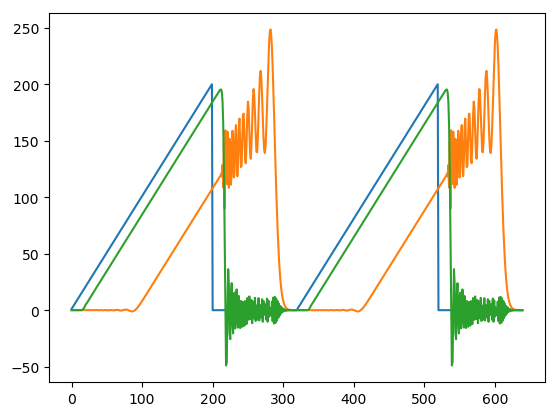

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x0000000062FE6860>

In [196]:
plt.plot(x)
plt.plot(xout1)
plt.plot(xout2)


In [197]:
x = vcat(collect(0:100), zeros(40));
Y = zeros(2*nr_freqs)
T, u = allpass_update_matrix2(nr_freqs, pole_location)
for k = 1:3*nr_freqs
    Y = T*Y + u*x[k]
end


In [207]:
taps = (Y[1:2:end])
tapsx = reverse(x[2*nr_freqs+1:3*nr_freqs]);

BoundsError: BoundsError: attempt to access 40-element Array{Float64,1} at index [81:120]

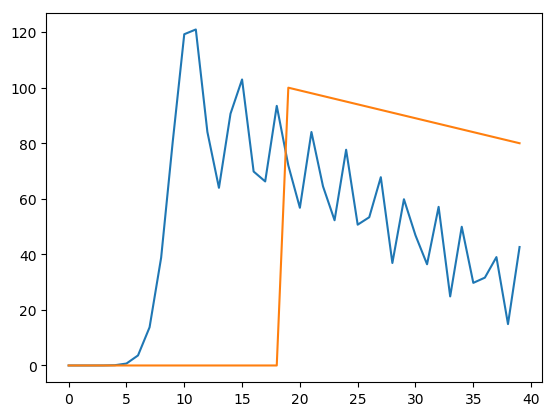

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x0000000063183438>

In [199]:
plt.plot(taps)
plt.plot(tapsx)

In [204]:
x = reverse(taps)
xi = []
Y = zeros(2*nr_freqs)
Y[1:2:end] = x
Y[2:2:end] = x
T, u = allpass_update_matrix2(nr_freqs, pole_location)
for k = 1:length(x)
    Y = T*Y #+ u*x[k]
    push!(xi, Y[end-1])
end

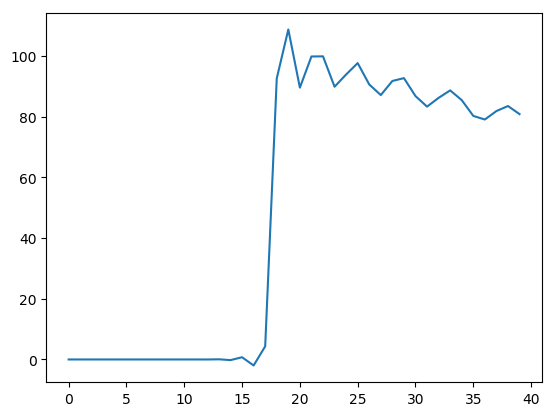

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x00000000631B3A58>

In [205]:
plt.plot(xi)

In [208]:
function preprocess(x::Array{Float64,1}, fs::Int64; fs_desired::Int64=8000, normalization_method::String="max")
    y = resample(x, fs_desired/fs)
    y = normalize(y, normalization_method)
    return y
end;

In [235]:
# load speech data
x_speech, fs_speech = wavread(sound_file1, format="native")
fs_speech = Int(fs_speech)
x_speech = convert(Array{Float64,1}, squeeze(x_speech[:,1]))[1*fs_speech:4*fs_speech]

# load noise data
x_noise, fs_noise = wavread(sound_file2, format="native")
fs_noise = Int(fs_noise)
x_noise = convert(Array{Float64,1}, squeeze(x_noise[:,1]))[1*fs_noise:4*fs_noise]

# pre-process signals
y_speech = preprocess(x_speech, fs_speech)
y_noise = preprocess(x_noise, fs_noise)
y_tot = y_noise + y_speech

# warp signal and take fft
f_speech = warp_fft(y_speech, pole_location, nr_freqs, step_size=step_size)
f_noise = warp_fft(y_noise, pole_location, nr_freqs, step_size=step_size)
f_tot = warp_fft(y_tot, pole_location, nr_freqs, step_size=step_size)

# get the log abs values
z_speech = log.(abs2.(f_speech))[:,1:Int(nr_freqs/2+1)]
z_noise = log.(abs2.(f_noise))[:,1:Int(nr_freqs/2+1)]
z_tot = log.(abs2.(f_tot))[:,1:Int(nr_freqs/2+1)]

# create audioplayers for signals
audioplayers(y_speech, y_noise, y_tot, fs=fs_desired)
;

<source src="data:audio/wav;base64,UklGRkB3AQBXQVZFZm10ICgAAAD+/wEAQB8AAAB9AAAEACAAFgAgAAAAAAADAAAAAAAQAIAAAKoAOJtxZGF0YQR3AQAXLxC+z7Zpvpv5Nb7BxRS+yVvfvUVPfL38sEc9gVMKPp4fZT6sOp8+RpLDPsjZwD5W47o+J/2cPmR09T0v+uG8ABMfvdIXpb07sH++OCiXvvv6Nb44zZu9eM6Yva0/Er1fmx09L+SrPe4cPj3Td6g79Y9svcGes72gmOG9KaAYvpjcUr7g8k++VXYXvuUq2b3Ba7S98BKWvE0V6z0WIGg+qiaSPtcnsj4xVMc+Y+TFPuDxqD69wBs+2NTxu1vSK71/F5i9vD17vvfDo77n4mO+8qS2vXTgrb10upW9vXA4PH9ivD1+8JY9nkMiPULRnrt0sj+9+GfJveM3A77Zhzq+DQNXvrM9OL6sCAi+sZXHvbpjMbzNJAw+UVOEPtSsoD7E7b8+lADZPjDuyz6qLmI+9XYmPSq+FjzI8Bi90mNgvt28t75p/Iu+A/EWvlMvCr6i3BS+HQoavQEv0D0Iq/89vKxwPfizijwG9Qs9jrqmPCbCrr3Z1zq+jNJEvjVxJL4keiC+3EEZvjBXnr2MpI49GgVMPhV4iz4g558+QLHGPmZX0j61LJs+IPC5Pav9lTn/17Q7GYnlvXvDpb5c6K6+oVxTvlTMHr71mze+1FzzveH14zuZzZg9n3yTPbNvHD2AEQ08FFl1PPSTUjyR6Kq94BgpvteY+r0ZPju9XzhLveXiVbvRpDA+MiaoPh8xsz4ljbg+wQigPhDOIj4g8aU9z/JTPUZa+r372qC+scqNvkacQL4qYV2++HlsvhJk0L1r9h49hYK2PZHD6z0FNvk9WjKdPVZphz1ds349YJgfvW9DQb4m1Ua+HMIFvp7XM75TKmy+RjEHvjgZTzxV2ng92D26PcCMOT4EqYI+i0mDPsGPVD6ugzA+nTT+Pd5ZkT3xbRC83llsvRsUeL2MM7K9Zi0lvnssI75Xrci9qmi8vUkO6b25a3+9WxlBPIrrMbp3VjG9LP9DvX5R6bw4Y8C8yXmxvHVINLt5PVw9ZmgYPgJFbz52tZA+wOSpPkjMvD4cb10+Vm88PAl83js3LbM8YPhIvo/NvL5g8nK+dWXcvZbBRL5zn12+/pvOvFIVBT4EjQA+pJjcPXo8Kz7HFUc+/HAiPkS9jD0YLKG8DyWqvVi5yL26PQi+6EhIvjMYSL690Oe9d5x2vfPRhb3/iQe93rIZPc3ImD1w7EI9tIwWPRM6Iz12ePo8nF+evDZ0Wr19ITy9syPvvG29Er15zyi9GHsOvY9/fLz0kdU7UhQJPK29SbuupwW79bNwPKqtezsR28C8Q+kXvUARabyojWC8mO+ovOtARztuQAE9O+oRPY3LIT1TEmI9vn2EPcHQgz3EujY99mz+PN5srjyxd388neOGvOCDPL1jlki9KPNLvaiFkr0oW6C9Ln1uvTsOVb1AKly951kvve3xuLxGoaq8Qf5avI9sMTqm8lU8kjemPCPtPz3CPog9JVyJPUujoj18Htg9md/QPdIjqj2p2nM9GmcyPcUijzz7qcK8CXCJvXfc273twPu9SAf9vdNDBr63pBO+BRbqvTnfoL1asH29sqw4vYkKU7yfsCY8TInsPATsOD2tXGA9K3CdPfjN+j19jx0+HJc2Pk8AST4o1Ds+PEj6PcNEoz1OXjE9YVF6vXRoFr6T7ya+3KYqvtU1Zb7x9m2+/j0qvj428r0Zzum9xu6fvX7Q07tXrfA89JYiPYvTgj1k0Mo9iFTtPf3jAj4mTCc+cPBTPtYIdj6udmU+htXiPdV63Dwge1M9vX+dPMapEr735k++J+/CvQP7yr1nqU++0uQkvl9bpLzLzSW82hRBvXOvBz2OiOY9xPysPeHRRz3ahps9njuJPdkRpbsLRiy9cQUIvVe1cr1lJMq934HHveZXrr21qKC9TDiGvUnZL71YbZq84zRIvNWEdrwBssm7wMkpPM4rejzys/m76LGTuz0cLTykokE675GBvJZF3zqYr4E7isl6vKC5mLzmlDK877QhvCFiBLzrGwe6r07jOw+O5TuOvjs8hukfPHiPyjzZqSc9jOQCPWK/kTygYcs8prkOPdttqjw/CpE8t4bXPGwJkTxap6Y6fBP7OREFTbvFfRa8XxkQvOODHryLh/a7pHUmvL8viLv2IGy6uT3bujm90juoq907o3DyOwS4qjx/f6E8uRUgPLAyxzzr6u08fnY0PIqvADzeMdU8HSPQPOZwLjwI0xA8sAVSOzILqTokr5Q8kIm7O6IDg7znR+I6RTyOPL3EVrrK1sK7JZYDPDQ/szrRZ7Y7AIsmPBIvLDtIeyE7jBFaPDsFgDwAARs7hH8RPMzaTDyuOTw8zlTBPF2iyLo6ZJE8tPL0PNly1DtaB6s8SWicPMMzlbt9/ms8v/nEPKj4t7sMHI68kXQfOylYF7wQM0S8jqePO/gdALyFJiO79ZswPACm2Lxa+Da82j4PPTaVJDyygB69V96ivIolHj2vutY7sk05va6Cgjyi37M8f8dDvao/ITxQohA9G/Y2vWzkG7087vA8ds8gvHZAQr26KMe8BatsOg8e1rzddmC8Z9CCvMRz77zPfvo7IMpiPB0xRb2nppq8vr/xPLrtm7y4cQO9cV1iO98/R7qi6Ka8G8mYvEQiyDua4ku8Ix3yvMQpU7xLgY27j9Z+vH5R9rxO21i8xhomvG8TZ7xzjhG8FGmnuzRCarpED0K7Piphu4HWE7vWSow7K2tVusQh+LvaO5m62L7Luia8LLosKQC89vnuuxNNsbuJ1mW7HxDcOpENmDrwfVe4H8NhO505vjtvWYq7umlcu/lLbLuzBRW8uSUyvJNWI7yYOge853JsvCCbcbzEExi8dieCu6qi/rqmyGa7amHZO4RmPzyjY+E7JtqRO9AZDTyP+NM7cx4kO2+gczs/Bqk6dB+yOZ95gToomHe6duJ8ul2fBLtO4IM5qREzO8exSLsmhMq7zkXQu2lzDLxGUwa80nASvEz5mLt5esG5IXlaOyU8qDvIF5S5t/+XO8gjFTylxNs7+IHMufnwGDtobfk7AQMcOzJSO7uFx3Y75hbiO3Wgfjvm6Ii6sF+SOzpfzDtW9v87eOkPPADrQjzBxjo819owPDZQOTwbKQY8BjQJPNf9CjzdWSo7tTmeOwf7yzsilA08p89APAge/jvKXPQ78RcLPC218jvtO9Q7+N7dO7FfPTxVjyM8TU6aO0H28zv+bxY8JLL2O1zUZjzSvH48ZMY1PJ4TETzei0A8wx/BO2GtgjuNAL47QZFhu90NubtkewK8cOGLu2ansbu81me7TgNhO5bEcDuRUjg61wsJO0ZtOjs/mCK6FAPBu2KV77vH1Cu8SXgivEy3TbwE/oe88OKTvF7TfbyEho+8oKyXvHYSUrxByne8n4aGvP3NirwysYK8B5mdvBpjp7wcYKO8sFe5vKGqrLxUgaq8/TygvG3eurwW+HG8vLFQvK58j7yxnl+8qD9bvMu4OLxnvYO8LF6jvEvuo7zclJ+8OtB+vK2Khbzr74G8D7R7vE80c7wNDI68VpiVvNH8dLyHfji8r5p/vEljY7yaeSO8jH4XvB9mILz6QYC7WDAFvBtELrykpfO7xXF9u0yikLvsYHK7A3zfu3nYPrtvjP43F5YGu1T9vTr3LmA6Xy8vOyoTaTtfRoo6rANJO+pBQzuGWLK7Gh0WusPwgzqXDfQ6mtKgOqpKgDtpneo70NaMO4hIyTslITU8UscMPGiMUDw313I8v+MoPDIvQzzHsAw8lpQ7PF8yGDxrCyM8mORJPLBP+Dufq/c7xpsjPJOQZDw86x48J6lAPCwxfjxhQDg8WXcQPC16VzwATHM8W3GKPEi8gjx/tHk8PXhuPLExmzxGg448aMlIPOf8QzyiX

<source src="data:audio/wav;base64,UklGRkB3AQBXQVZFZm10ICgAAAD+/wEAQB8AAAB9AAAEACAAFgAgAAAAAAADAAAAAAAQAIAAAKoAOJtxZGF0YQR3AQAXLxC+z7Zpvpv5Nb7BxRS+yVvfvUVPfL38sEc9gVMKPp4fZT6sOp8+RpLDPsjZwD5W47o+J/2cPmR09T0v+uG8ABMfvdIXpb07sH++OCiXvvv6Nb44zZu9eM6Yva0/Er1fmx09L+SrPe4cPj3Td6g79Y9svcGes72gmOG9KaAYvpjcUr7g8k++VXYXvuUq2b3Ba7S98BKWvE0V6z0WIGg+qiaSPtcnsj4xVMc+Y+TFPuDxqD69wBs+2NTxu1vSK71/F5i9vD17vvfDo77n4mO+8qS2vXTgrb10upW9vXA4PH9ivD1+8JY9nkMiPULRnrt0sj+9+GfJveM3A77Zhzq+DQNXvrM9OL6sCAi+sZXHvbpjMbzNJAw+UVOEPtSsoD7E7b8+lADZPjDuyz6qLmI+9XYmPSq+FjzI8Bi90mNgvt28t75p/Iu+A/EWvlMvCr6i3BS+HQoavQEv0D0Iq/89vKxwPfizijwG9Qs9jrqmPCbCrr3Z1zq+jNJEvjVxJL4keiC+3EEZvjBXnr2MpI49GgVMPhV4iz4g558+QLHGPmZX0j61LJs+IPC5Pav9lTn/17Q7GYnlvXvDpb5c6K6+oVxTvlTMHr71mze+1FzzveH14zuZzZg9n3yTPbNvHD2AEQ08FFl1PPSTUjyR6Kq94BgpvteY+r0ZPju9XzhLveXiVbvRpDA+MiaoPh8xsz4ljbg+wQigPhDOIj4g8aU9z/JTPUZa+r372qC+scqNvkacQL4qYV2++HlsvhJk0L1r9h49hYK2PZHD6z0FNvk9WjKdPVZphz1ds349YJgfvW9DQb4m1Ua+HMIFvp7XM75TKmy+RjEHvjgZTzxV2ng92D26PcCMOT4EqYI+i0mDPsGPVD6ugzA+nTT+Pd5ZkT3xbRC83llsvRsUeL2MM7K9Zi0lvnssI75Xrci9qmi8vUkO6b25a3+9WxlBPIrrMbp3VjG9LP9DvX5R6bw4Y8C8yXmxvHVINLt5PVw9ZmgYPgJFbz52tZA+wOSpPkjMvD4cb10+Vm88PAl83js3LbM8YPhIvo/NvL5g8nK+dWXcvZbBRL5zn12+/pvOvFIVBT4EjQA+pJjcPXo8Kz7HFUc+/HAiPkS9jD0YLKG8DyWqvVi5yL26PQi+6EhIvjMYSL690Oe9d5x2vfPRhb3/iQe93rIZPc3ImD1w7EI9tIwWPRM6Iz12ePo8nF+evDZ0Wr19ITy9syPvvG29Er15zyi9GHsOvY9/fLz0kdU7UhQJPK29SbuupwW79bNwPKqtezsR28C8Q+kXvUARabyojWC8mO+ovOtARztuQAE9O+oRPY3LIT1TEmI9vn2EPcHQgz3EujY99mz+PN5srjyxd388neOGvOCDPL1jlki9KPNLvaiFkr0oW6C9Ln1uvTsOVb1AKly951kvve3xuLxGoaq8Qf5avI9sMTqm8lU8kjemPCPtPz3CPog9JVyJPUujoj18Htg9md/QPdIjqj2p2nM9GmcyPcUijzz7qcK8CXCJvXfc273twPu9SAf9vdNDBr63pBO+BRbqvTnfoL1asH29sqw4vYkKU7yfsCY8TInsPATsOD2tXGA9K3CdPfjN+j19jx0+HJc2Pk8AST4o1Ds+PEj6PcNEoz1OXjE9YVF6vXRoFr6T7ya+3KYqvtU1Zb7x9m2+/j0qvj428r0Zzum9xu6fvX7Q07tXrfA89JYiPYvTgj1k0Mo9iFTtPf3jAj4mTCc+cPBTPtYIdj6udmU+htXiPdV63Dwge1M9vX+dPMapEr735k++J+/CvQP7yr1nqU++0uQkvl9bpLzLzSW82hRBvXOvBz2OiOY9xPysPeHRRz3ahps9njuJPdkRpbsLRiy9cQUIvVe1cr1lJMq934HHveZXrr21qKC9TDiGvUnZL71YbZq84zRIvNWEdrwBssm7wMkpPM4rejzys/m76LGTuz0cLTykokE675GBvJZF3zqYr4E7isl6vKC5mLzmlDK877QhvCFiBLzrGwe6r07jOw+O5TuOvjs8hukfPHiPyjzZqSc9jOQCPWK/kTygYcs8prkOPdttqjw/CpE8t4bXPGwJkTxap6Y6fBP7OREFTbvFfRa8XxkQvOODHryLh/a7pHUmvL8viLv2IGy6uT3bujm90juoq907o3DyOwS4qjx/f6E8uRUgPLAyxzzr6u08fnY0PIqvADzeMdU8HSPQPOZwLjwI0xA8sAVSOzILqTokr5Q8kIm7O6IDg7znR+I6RTyOPL3EVrrK1sK7JZYDPDQ/szrRZ7Y7AIsmPBIvLDtIeyE7jBFaPDsFgDwAARs7hH8RPMzaTDyuOTw8zlTBPF2iyLo6ZJE8tPL0PNly1DtaB6s8SWicPMMzlbt9/ms8v/nEPKj4t7sMHI68kXQfOylYF7wQM0S8jqePO/gdALyFJiO79ZswPACm2Lxa+Da82j4PPTaVJDyygB69V96ivIolHj2vutY7sk05va6Cgjyi37M8f8dDvao/ITxQohA9G/Y2vWzkG7087vA8ds8gvHZAQr26KMe8BatsOg8e1rzddmC8Z9CCvMRz77zPfvo7IMpiPB0xRb2nppq8vr/xPLrtm7y4cQO9cV1iO98/R7qi6Ka8G8mYvEQiyDua4ku8Ix3yvMQpU7xLgY27j9Z+vH5R9rxO21i8xhomvG8TZ7xzjhG8FGmnuzRCarpED0K7Piphu4HWE7vWSow7K2tVusQh+LvaO5m62L7Luia8LLosKQC89vnuuxNNsbuJ1mW7HxDcOpENmDrwfVe4H8NhO505vjtvWYq7umlcu/lLbLuzBRW8uSUyvJNWI7yYOge853JsvCCbcbzEExi8dieCu6qi/rqmyGa7amHZO4RmPzyjY+E7JtqRO9AZDTyP+NM7cx4kO2+gczs/Bqk6dB+yOZ95gToomHe6duJ8ul2fBLtO4IM5qREzO8exSLsmhMq7zkXQu2lzDLxGUwa80nASvEz5mLt5esG5IXlaOyU8qDvIF5S5t/+XO8gjFTylxNs7+IHMufnwGDtobfk7AQMcOzJSO7uFx3Y75hbiO3Wgfjvm6Ii6sF+SOzpfzDtW9v87eOkPPADrQjzBxjo819owPDZQOTwbKQY8BjQJPNf9CjzdWSo7tTmeOwf7yzsilA08p89APAge/jvKXPQ78RcLPC218jvtO9Q7+N7dO7FfPTxVjyM8TU6aO0H28zv+bxY8JLL2O1zUZjzSvH48ZMY1PJ4TETzei0A8wx/BO2GtgjuNAL47QZFhu90NubtkewK8cOGLu2ansbu81me7TgNhO5bEcDuRUjg61wsJO0ZtOjs/mCK6FAPBu2KV77vH1Cu8SXgivEy3TbwE/oe88OKTvF7TfbyEho+8oKyXvHYSUrxByne8n4aGvP3NirwysYK8B5mdvBpjp7wcYKO8sFe5vKGqrLxUgaq8/TygvG3eurwW+HG8vLFQvK58j7yxnl+8qD9bvMu4OLxnvYO8LF6jvEvuo7zclJ+8OtB+vK2Khbzr74G8D7R7vE80c7wNDI68VpiVvNH8dLyHfji8r5p/vEljY7yaeSO8jH4XvB9mILz6QYC7WDAFvBtELrykpfO7xXF9u0yikLvsYHK7A3zfu3nYPrtvjP43F5YGu1T9vTr3LmA6Xy8vOyoTaTtfRoo6rANJO+pBQzuGWLK7Gh0WusPwgzqXDfQ6mtKgOqpKgDtpneo70NaMO4hIyTslITU8UscMPGiMUDw313I8v+MoPDIvQzzHsAw8lpQ7PF8yGDxrCyM8mORJPLBP+Dufq/c7xpsjPJOQZDw86x48J6lAPCwxfjxhQDg8WXcQPC16VzwATHM8W3GKPEi8gjx/tHk8PXhuPLExmzxGg448aMlIPOf8QzyiX

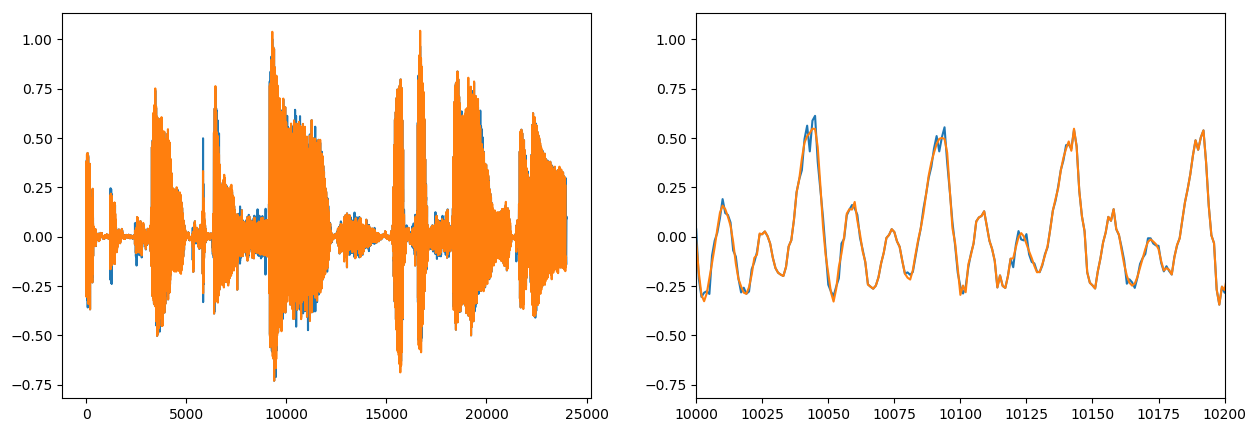

In [236]:
include("../functions/preprocessing.jl")

zi_speech = warp_ifft(f_speech, pole_location, step_size)

_, ax = plt.subplots(ncols=2, figsize=(15,5))
ax[1].plot(y_speech)
ax[1].plot(zi_speech)
ax[2].plot(y_speech)
ax[2].plot(zi_speech)
ax[2].set_xlim(10000, 10200)
audioplayers(y_speech, zi_speech, fs=fs_desired)